In [1]:
import numpy as np
import random
import json
import pickle
import os
import cma

from BatAlgorithm import bat_algorithm
from ArtificialBeeColony import artificial_bee_colony
from GeneticAlgorithm import (
    genetic_algorithm,
    arithmetic_crossover,
    single_point_crossover,
    gaussian_mutation,
    uniform_mutation
)
from plotConvergence import plot_convergence
from animateAlgorithms import animate_algorithm

from objective_functions import sphere_function, rastrigin_function, rosenbrock_function

In [2]:
class MetaheuristicTuner:

    def __init__(self):
        # Na przyszłość pod frontend (start/stop) – teraz nieużywana
        self.is_stopped = False

        # Folder na wszystkie pliki
        self.folder = "checkpoints"
        os.makedirs(self.folder, exist_ok=True)

        # Plik globalnego stanu tunera
        self.tuner_state_file = os.path.join(self.folder, "tuner_state.json")

        # ============================
        # PARAMETRY ALGORYTMÓW
        # (tylko liczbowe – GA bez kategorycznych)
        # ============================
        self.param_spaces = {
            "BAT": {
                "n_bats": (10, 50, "int"),
                "max_iter": (50, 200, "int"),
                "alpha": (0.1, 1.0, "float"),
                "gamma": (0.1, 1.0, "float"),
                "f_bounds_min": (0, 2, "float"),
                "f_bounds_max": (2, 5, "float")
            },

            "ABC": {
                "n_bees": (10, 50, "int"),
                "max_iter": (50, 200, "int")
            },

            # Uwaga: brak crossover_type / mutation_type w param_spaces
            "GA": {
                "pop_size": (20, 100, "int"),
                "max_generations": (100, 500, "int"),
                "crossover_rate": (0.5, 0.95, "float"),
                "mutation_rate": (0.001, 0.1, "float"),
                "mutation_scale": (0.01, 0.5, "float"),
                "elitism_rate": (0.05, 0.3, "float"),
                "tournament_size": (2, 5, "int")
            }
        }

        # ============================
        # FUNKCJE TESTOWE
        # ============================
        self.test_functions = {
            "sphere": {
                "func": sphere_function,
                "bounds": (-10, 10)
            },
            "rastrigin": {
                "func": rastrigin_function,
                "bounds": (-5.12, 5.12)
            },
            "rosenbrock": {
                "func": rosenbrock_function,
                "bounds": (-10, 10)
            }
        }

        # ============================
        # WRAPPERY ALGORYTMÓW
        # ============================
        self.runners = {
            "BAT": self.run_BAT,
            "ABC": self.run_ABC,
            "GA": self.run_GA
        }

    # ============================================================
    # WRAPPERY ALGORYTMÓW
    # ============================================================

    def run_BAT(self, params, objective_func, bounds, dim):
        _, best_value, _, _ = bat_algorithm(
            fn=objective_func,
            n_bats=params["n_bats"],
            bounds=bounds,
            max_iter=params["max_iter"],
            dims=dim,
            alpha=params["alpha"],
            gamma=params["gamma"],
            f_bounds=(params["f_bounds_min"], params["f_bounds_max"])
        )
        return best_value

    def run_ABC(self, params, objective_func, bounds, dim):
        _, best_value, _, _ = artificial_bee_colony(
            n_bees=params["n_bees"],
            dim=dim,
            bounds=bounds,
            max_iter=params["max_iter"],
            objective_func=objective_func
        )
        return best_value

    def run_GA(self, params, objective_func, bounds, dim):
        """
        Tutaj params ZAWIERA JUŻ zmapowane:
        - params["crossover_type"] in {"arithmetic", "single_point"}
        - params["mutation_type"]  in {"uniform", "gaussian"}
        bo zostały nadane w vector_to_params().
        """

        crossover_type = params["crossover_type"]
        mutation_type  = params["mutation_type"]

        crossover = (
            arithmetic_crossover if crossover_type == "arithmetic"
            else single_point_crossover
        )

        mutation = (
            uniform_mutation if mutation_type == "uniform"
            else gaussian_mutation
        )

        _, best_value, _, _ = genetic_algorithm(
            dim=dim,
            pop_size=params["pop_size"],
            objective_func=objective_func,
            bounds=bounds,
            max_generations=params["max_generations"],
            crossover_rate=params["crossover_rate"],
            mutation_rate=params["mutation_rate"],
            mutation_scale=params["mutation_scale"],
            elitism_rate=params["elitism_rate"],
            tournament_size=params["tournament_size"],
            crossover_type=crossover,
            mutation_type=mutation
        )

        return best_value

    # ============================================================
    # FUNKCJA CELU
    # ============================================================

    def evaluate_params(self, params, runner, selected_funcs, dim, R=20):
        sigmas = []

        for f_name in selected_funcs:
            meta = self.test_functions[f_name]
            func = meta["func"]
            bounds = meta["bounds"]

            results = []

            for r in range(R):
                np.random.seed(r)
                random.seed(r)
                value = runner(params, func, bounds, dim)
                results.append(value)

            sigmas.append(np.std(results))

        return np.mean(sigmas)

    # ============================================================
    # KONWERSJA WEKTORA CMA → PARAMETRY
    # (tu dokładamy kategorie dla GA)
    # ============================================================

    def vector_to_params(self, x, param_space, algorithm):
        params = {}
        i = 0

        # najpierw parametry z param_spaces
        for name, (pmin, pmax, ptype) in param_space.items():
            val = x[i]
            val = max(pmin, min(pmax, val))

            if ptype == "int":
                val = int(round(val))

            params[name] = val
            i += 1

        # dodatkowe wymiary dla GA – kategoryczne
        if algorithm == "GA":
            # dwa ostatnie wymiary CMA-ES traktujemy jako kategorie 0/1
            crossover_raw = int(round(x[i]))
            mutation_raw  = int(round(x[i + 1]))

            # clamp
            crossover_raw = max(0, min(1, crossover_raw))
            mutation_raw  = max(0, min(1, mutation_raw))

            crossover_type = "arithmetic" if crossover_raw == 0 else "single_point"
            mutation_type  = "uniform"    if mutation_raw  == 0 else "gaussian"

            params["crossover_type"] = crossover_type
            params["mutation_type"]  = mutation_type

        return params

    # ============================================================
    # TUNER JEDNEGO ALGORYTMU
    # ============================================================

    def tune_single_algorithm(self, algorithm, selected_funcs, dim,
                              iterations=30, R=20, stop_after_iter=None):
        """
        stop_after_iter - tylko do testów w Jupyterze:
        jeśli nie-None, przerywa po podanej liczbie iteracji CMA-ES.
        """

        param_space = self.param_spaces[algorithm]
        runner = self.runners[algorithm]

        checkpoint_json = os.path.join(self.folder, f"checkpoint_{algorithm}.json")
        checkpoint_pkl  = os.path.join(self.folder, f"checkpoint_{algorithm}.pkl")

        es = None
        start_iter = 0

        # ====== WZNOWIENIE ======
        if os.path.exists(checkpoint_json) and os.path.exists(checkpoint_pkl):
            print(f"Wznawiam tuner {algorithm} z checkpointu...")

            with open(checkpoint_json, "r") as f:
                data = json.load(f)
                start_iter = data["current_iteration"]

            with open(checkpoint_pkl, "rb") as f:
                es = pickle.load(f)

        else:
            print(f"Startuję tuner {algorithm} od początku...")

            # liczba wymiarów liczbowych
            base_dim = len(param_space)

            # dla GA dokładamy 2 kategoryczne (crossover, mutation)
            extra_dims = 2 if algorithm == "GA" else 0
            total_dim = base_dim + extra_dims

            # x0: środek zakresu dla parametrów liczbowych + 0.5 dla kategorii
            x0 = [(pmin + pmax) / 2 for (pmin, pmax, _) in param_space.values()]
            for _ in range(extra_dims):
                x0.append(0.5)

            sigma0 = 0.3
            es = cma.CMAEvolutionStrategy(x0, sigma0)

        # ====== GŁÓWNA PĘTLA ======
        for it in range(start_iter, iterations):

            # Symulowane zatrzymanie (testowe)
            if stop_after_iter is not None and it >= stop_after_iter:
                print(f"Symulowane zatrzymanie tunera {algorithm} na iteracji {it}.")
                return None

            print(f"\nIteracja tunera ({algorithm}): {it+1}/{iterations}")

            solutions = es.ask()
            fitness = []

            for x in solutions:
                params = self.vector_to_params(x, param_space, algorithm)
                fval = self.evaluate_params(params, runner, selected_funcs, dim, R)
                fitness.append(fval)

            es.tell(solutions, fitness)
            es.disp()

            # ====== ZAPIS CHECKPOINTU ======
            with open(checkpoint_pkl, "wb") as f:
                pickle.dump(es, f)

            with open(checkpoint_json, "w") as f:
                json.dump({
                    "algorithm": algorithm,
                    "selected_funcs": selected_funcs,
                    "dim": dim,
                    "iterations": iterations,
                    "R": R,
                    "current_iteration": it + 1
                }, f)

        # Koniec strojenia tego algorytmu – pobieramy najlepsze parametry
        best_vector = es.result.xbest
        best_params = self.vector_to_params(best_vector, param_space, algorithm)

        return best_params

    def generate_figures(self, best, alg, dim, selected_funcs):
        figure = {}
        for f_name in selected_funcs:
            figure[f_name] = {}
            meta = self.test_functions[f_name]
            func = meta["func"]
            bounds = meta["bounds"]
            if alg == "ABC":
                _, _, convergence_curve, positions_log = artificial_bee_colony(best['n_bees'], dim, bounds, best['max_iter'], func, limit=None)
            if alg == "BAT":
                _, _, convergence_curve, positions_log = bat_algorithm(func, best['n_bats'], bounds, best['max_iter'], dim, best['alpha'], best['gamma'], (best['f_bounds_min'], best['f_bounds_max']))
            if alg == "GA":
                crossover = (arithmetic_crossover if best['crossover_type'] == 0 else single_point_crossover)
                mutation = (gaussian_mutation if best['mutation_type'] == 0 else uniform_mutation)
                _, _, convergence_curve, positions_log = genetic_algorithm(best['pop_size'], dim, bounds, best['max_generations'], func, best['crossover_rate'], best['mutation_rate'], best['mutation_scale'], best['elitism_rate'], best['tournament_size'], crossover, mutation)

            convergence_plot_base64 = plot_convergence(convergence_curve, alg, f_name)
            figure[f_name]['convergence_plot'] = convergence_plot_base64
            if dim == 2:
                animation_base64 = animate_algorithm(positions_log, [bounds, bounds], func)
                figure[f_name]['animation'] = animation_base64

        return figure

    # ============================================================
    # TUNER WIELU ALGORYTMÓW
    # ============================================================

    def tune_algorithms(self, selected, selected_funcs, dim,
                        iterations=30, R=20, stop_after_iter=None):
        """
        selected: lista algorytmów, np. ["ABC", "GA"]
        stop_after_iter: tylko testowo (Jupyter), przekazywane do tune_single_algorithm
        """

        results = {}

        # ====== WZNOWIENIE GLOBALNE (który algorytm był ostatnio) ======
        if os.path.exists(self.tuner_state_file):
            with open(self.tuner_state_file, "r") as f:
                state = json.load(f)
                start_index = state["current_algorithm_index"]
                saved_selected = state["selected_algorithms"]
            print(f"Wznawiam tuning od algorytmu index {start_index}.")
            # można dodać asercję, że selected == saved_selected
        else:
            start_index = 0

        # ====== Wczytujemy wyniki algorytmów, które już były ukończone ======
        for j in range(start_index):
            alg_done = selected[j]
            res_file = os.path.join(self.folder, f"results_{alg_done}.json")
            if os.path.exists(res_file):
                with open(res_file, "r") as f:
                    results[alg_done] = json.load(f)

        # ====== PĘTLA ALGORYTMÓW ======
        for i in range(start_index, len(selected)):

            alg = selected[i]
            print(f"\n=== Zaczynam algorytm: {alg} ===")

            best = self.tune_single_algorithm(
                algorithm=alg,
                selected_funcs=selected_funcs,
                dim=dim,
                iterations=iterations,
                R=R,
                stop_after_iter=stop_after_iter
            )

            # Jeśli przerwano (stop_after_iter): nie kasujemy checkpointów, nie usuwamy wyników
            if best is None:
                print(f"Tuner przerwany podczas strojenia algorytmu {alg}.")
                # Zapisujemy stan globalny, żeby wznowić od TEGO algorytmu
                with open(self.tuner_state_file, "w") as f:
                    json.dump({
                        "current_algorithm_index": i,
                        "selected_algorithms": selected
                    }, f)
                return results if results else None

            results[alg] = best

            # Zapis wyniku algorytmu do osobnego pliku
            res_file = os.path.join(self.folder, f"results_{alg}.json")
            with open(res_file, "w") as f:
                json.dump(best, f)

            # Zapis globalnego postępu – przechodzimy do następnego algorytmu
            with open(self.tuner_state_file, "w") as f:
                json.dump({
                    "current_algorithm_index": i + 1,
                    "selected_algorithms": selected
                }, f)

            # Skoro algorytm został w pełni ukończony, możemy usunąć jego checkpointy
            checkpoint_json = os.path.join(self.folder, f"checkpoint_{alg}.json")
            checkpoint_pkl  = os.path.join(self.folder, f"checkpoint_{alg}.pkl")

            if os.path.exists(checkpoint_json):
                os.remove(checkpoint_json)
            if os.path.exists(checkpoint_pkl):
                os.remove(checkpoint_pkl)

        figures = {}
        for alg in selected:
            if alg in results:  # Tylko dla ukończonych algorytmów
                figure = self.generate_figures(results[alg], alg, dim, selected_funcs)
                figures[alg] = figure

        # ====== SPRZĄTANIE PO CAŁYM TUNINGU ======
        if os.path.exists(self.tuner_state_file):
            os.remove(self.tuner_state_file)

        # czyścimy też pliki results_* (żeby nie zaśmiecać)
        for alg in selected:
            res_file = os.path.join(self.folder, f"results_{alg}.json")
            if os.path.exists(res_file):
                os.remove(res_file)

        return results, figures

In [3]:
tuner = MetaheuristicTuner()

results, figures = tuner.tune_algorithms(
    selected=["ABC"],
    selected_funcs=["sphere"],
    dim=2,
    iterations=3,
    R=5
)

print("\n=== Wyniki strojenia (pełne) ===")
for alg, params in results.items():
    print(alg, "->", params)


=== Zaczynam algorytm: ABC ===
Startuję tuner ABC od początku...
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=765749, Mon Jan  5 17:18:35 2026)

Iteracja tunera (ABC): 1/3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.931729317397582e-33 1.0e+00 2.88e-01  3e-01  3e-01 0:04.4

Iteracja tunera (ABC): 2/3
    2     12 3.931729317397582e-33 1.4e+00 3.48e-01  3e-01  4e-01 0:08.7

Iteracja tunera (ABC): 3/3
    3     18 3.931729317397582e-33 1.8e+00 5.18e-01  5e-01  6e-01 0:13.2

=== Wyniki strojenia (pełne) ===
ABC -> {'n_bees': 29, 'max_iter': 125}



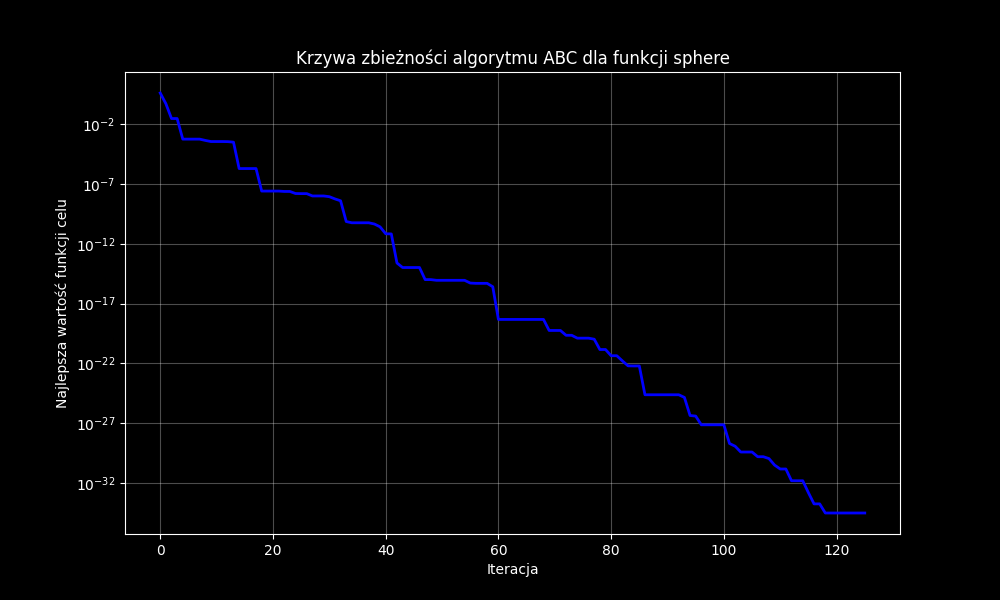


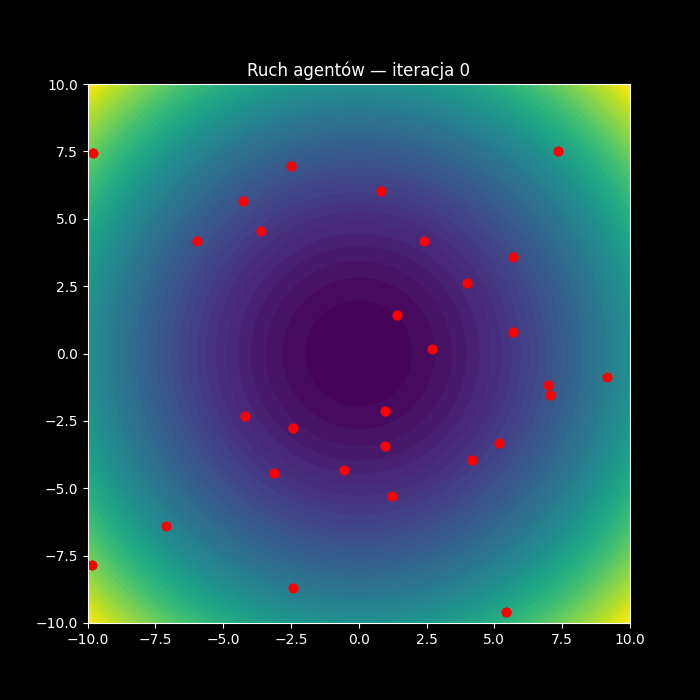


 -------------------- 



In [5]:
from IPython.display import HTML, display

display(HTML(f'<img src="data:image/png;base64,{figures['ABC']['sphere']['convergence_plot']}" width="600">'))
display(HTML(f'<img src="data:image/gif;base64,{figures['ABC']['sphere']['animation']}" width="600">'))

print('\n','-'*20,'\n')

# display(HTML(f'<img src="data:image/png;base64,{figures['GA']['rastrigin']['convergence_plot']}" width="600">'))
# display(HTML(f'<img src="data:image/gif;base64,{figures['GA']['rastrigin']['animation']}" width="600">'))